<a href="https://colab.research.google.com/github/WayneGretzky1/CSCI-4521-Applied-Machine-Learning/blob/main/bye00035Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Section 1

In [42]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    precision_recall_fscore_support,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
###### option 1: adding data to your drive and importing from there
from google.colab import drive
drive.mount('/content/drive/')

BASE_PATH = '/content/drive/MyDrive/CSCI4521_HW4_Dataset'
######

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
###### option 2: dragging the data to colab and going through it here
!unzip ./skin_cancer.zip
BASE_PATH = './skin_cancer/'
######


Streaming output truncated to the last 5000 lines.
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029321_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029322_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029323_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029324_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029325_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029326_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029327_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029328_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029329_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029330_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029331_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029332_segmenta

In [6]:
IMAGE_DIR = os.path.join(BASE_PATH, 'HAM10000_images')
MASK_DIR = os.path.join(BASE_PATH, 'HAM10000_segmentations')
METADATA_PATH = os.path.join(BASE_PATH, 'HAM10000_metadata.csv')

metadata_df = pd.read_csv(METADATA_PATH)

In [7]:
metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [8]:
#### create binary classification column for the images
malignant_map = {'mel': 1, 'bcc': 1, 'akiec': 1}
benign_map = {'nv': 0, 'bkl': 0, 'vasc': 0, 'df': 0}
metadata_df['binary_label'] = metadata_df['dx'].map(malignant_map).fillna(metadata_df['dx'].map(benign_map)).astype(int)

#### create multiclass classification column for the images
class_to_idx = {cls: i for i, cls in enumerate(metadata_df['dx'].unique())}
idx_to_class = {i: cls for cls, i in class_to_idx.items()}
metadata_df['multiclass_label'] = metadata_df['dx'].map(class_to_idx)

#### create image and mask path column for the images
image_paths = {os.path.splitext(f)[0]: os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)}
mask_paths = {os.path.splitext(f)[0].replace('_segmentation', ''): os.path.join(MASK_DIR, f) for f in os.listdir(MASK_DIR)}

metadata_df['image_path'] = metadata_df['image_id'].map(image_paths)
metadata_df['mask_path'] = metadata_df['image_id'].map(mask_paths)
metadata_df = metadata_df.dropna(subset=['image_path', 'mask_path'])

In [9]:
metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,binary_label,multiclass_label,image_path,mask_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,0,0,/content/drive/MyDrive/CSCI4521_HW4_Dataset/HA...,/content/drive/MyDrive/CSCI4521_HW4_Dataset/HA...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,0,0,/content/drive/MyDrive/CSCI4521_HW4_Dataset/HA...,/content/drive/MyDrive/CSCI4521_HW4_Dataset/HA...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,0,0,/content/drive/MyDrive/CSCI4521_HW4_Dataset/HA...,/content/drive/MyDrive/CSCI4521_HW4_Dataset/HA...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,0,0,/content/drive/MyDrive/CSCI4521_HW4_Dataset/HA...,/content/drive/MyDrive/CSCI4521_HW4_Dataset/HA...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,0,0,/content/drive/MyDrive/CSCI4521_HW4_Dataset/HA...,/content/drive/MyDrive/CSCI4521_HW4_Dataset/HA...


In [10]:
class HAM10000Dataset(Dataset):
    def __init__(self, df, use_mask=True, img_size=128, is_train=False, augmentation=None):
        self.df = df
        self.use_mask = use_mask
        self.img_size = img_size
        self.is_train = is_train
        self.augmentation = augmentation

        self.resize = transforms.Resize((img_size, img_size))
        self.to_tensor = transforms.ToTensor()

        self.color_jitter = None
        self.hflip = None
        self.rotation_degrees = None

        if self.is_train and augmentation:
            self.color_jitter = augmentation.get('color_jitter')
            self.hflip = augmentation.get('hflip', False)
            self.rotation_degrees = augmentation.get('rotation')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        mask_path = row['mask_path']
        binary_label = torch.tensor(row['binary_label'], dtype=torch.float32)
        multiclass_label = torch.tensor(row['multiclass_label'], dtype=torch.long)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = self.resize(image)
        mask = self.resize(mask)

        if self.is_train:
            if self.hflip and torch.rand(1) < 0.5:
                image = transforms.functional.hflip(image)
                mask = transforms.functional.hflip(mask)

            if self.rotation_degrees:
                angle = transforms.RandomRotation.get_params(self.rotation_degrees)
                image = transforms.functional.rotate(image, angle)
                mask = transforms.functional.rotate(mask, angle)

        if self.is_train and self.color_jitter:
            image = self.color_jitter(image)

        image = self.to_tensor(image)
        mask = self.to_tensor(mask)

        if self.use_mask:
            mask = (mask > 0.5).float()
            image = image * mask

        return image, binary_label, multiclass_label, row['image_id']

In [11]:
# useful functions

# turn the tensor dataset into numpy for SKLearn
def preprocess_for_sklearn(df, img_size):
  X = []
  y = []

  transform_q2 = transforms.Compose([
      transforms.Resize((img_size, img_size)),
      transforms.ToTensor()
  ])

  for _, row in df.iterrows():
      image = Image.open(row['image_path']).convert("RGB")
      mask = Image.open(row['mask_path']).convert("L")

      image_tensor = transform_q2(image)
      mask_tensor = transform_q2(mask)

      mask_tensor = (mask_tensor > 0.5).float()
      masked_image = image_tensor * mask_tensor

      X.append(masked_image.numpy().flatten())
      y.append(row['binary_label'])

  return np.array(X), np.array(y)

# helper function to visualiza an image
def imshow(img, title=None):
  img = img.numpy().transpose((1, 2, 0))
  img = np.clip(img, 0, 1)
  plt.imshow(img)
  if title:
      plt.title(title)
  plt.axis('off')

In [12]:
# create dataset for Q1
augmentation_q1 = {
    'color_jitter': transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    'hflip': True,
    'rotation': (-15, 15)
}

IMG_SIZE_Q1 = 128
BATCH_SIZE_Q1 = 32
EPOCHS_Q1 = 15
LR_Q1 = 0.001

dataset_q1 = HAM10000Dataset(metadata_df, use_mask=True, img_size=IMG_SIZE_Q1, is_train=True, augmentation=augmentation_q1)

torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


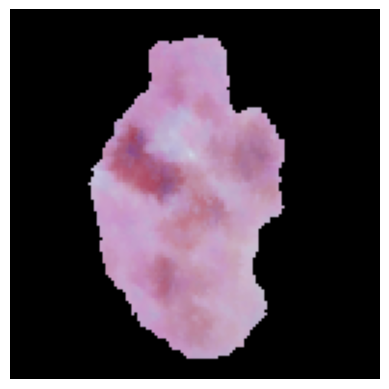

In [13]:
# example usage to get a data point
image, binary_label, multiclass_label, row = dataset_q1[0]
# image here is in RGB format with width and height!
print(image.shape)
print(dataset_q1[0][0].shape) # another way of getting the first image
# visualizing the image
imshow(image)

Q1

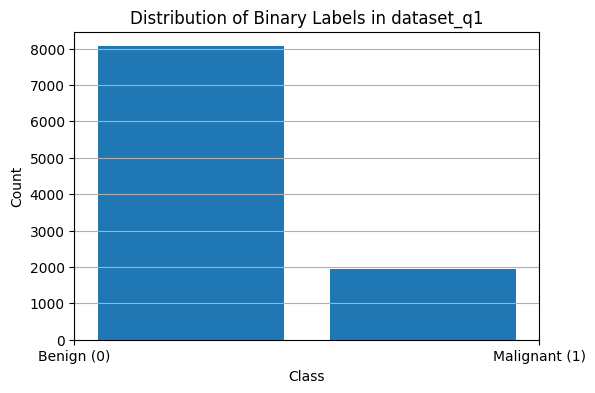

In [14]:
labels_series = pd.Series(metadata_df['binary_label'])

# Plot histogram
plt.figure(figsize=(6,4))
labels_series.hist(bins=2, rwidth=0.8)
plt.xticks([0,1], ['Benign (0)', 'Malignant (1)'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Binary Labels in dataset_q1")
plt.show()

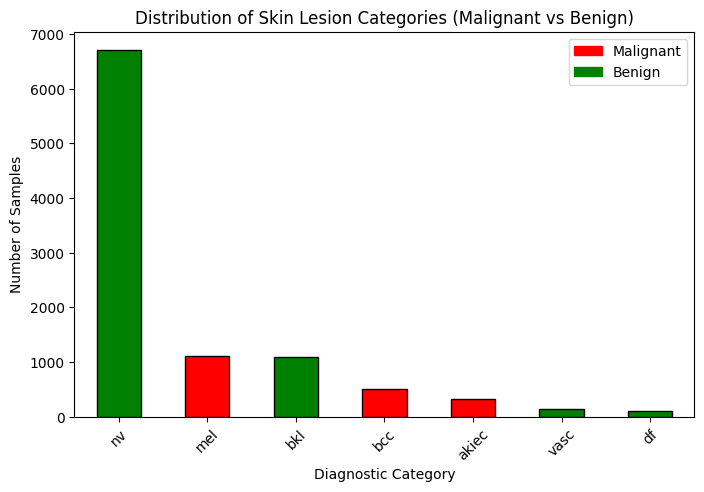

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [15]:
category_counts = metadata_df['dx'].value_counts()
malignant_classes = ['mel', 'bcc', 'akiec']
benign_classes = ['nv', 'bkl', 'vasc', 'df']
colors = ['red' if cls in malignant_classes else 'green' for cls in category_counts.index]

plt.figure(figsize=(8,5))
category_counts.plot(kind='bar', color=colors, edgecolor='black')
plt.xlabel("Diagnostic Category")
plt.ylabel("Number of Samples")
plt.title("Distribution of Skin Lesion Categories (Malignant vs Benign)")
plt.xticks(rotation=45)
plt.legend(handles=[
    plt.Rectangle((0,0),1,1,color='red', label='Malignant'),
    plt.Rectangle((0,0),1,1,color='green', label='Benign')
])
plt.show()
print(category_counts)


In [16]:
# Split metadata_df
train_df, test_df = train_test_split(metadata_df, test_size=0.2, random_state=42)

# Balance the training set by diagnostic category
nv = train_df[train_df['dx'] == 'nv']
mel = train_df[train_df['dx'] == 'mel']
bkl = train_df[train_df['dx'] == 'bkl']
bcc = train_df[train_df['dx'] == 'bcc']
akiec = train_df[train_df['dx'] == 'akiec']
vasc = train_df[train_df['dx'] == 'vasc']
df_ = train_df[train_df['dx'] == 'df']

# Targets
target_malignant = 1100
target_benign_total = 3300
nv_target = target_benign_total - (len(bkl) + len(vasc) + len(df_))
nv_target = max(0, nv_target)

# Downsample nv and keep small benign classes the same, bkl, vasc, df_
nv_down = resample(nv, replace=False, n_samples=nv_target, random_state=42)

# Oversample malignant to equal targets
mel_target = min(len(mel), target_malignant)
mel_bal = resample(mel, replace=False, n_samples=mel_target, random_state=42)
bcc_up = resample(bcc, replace=True, n_samples=target_malignant, random_state=42)
akiec_up = resample(akiec, replace=True, n_samples=target_malignant, random_state=42)

# Recombine
train_df_balanced = pd.concat([
    nv_down, bkl, vasc, df_,
    mel_bal, bcc_up, akiec_up
]).sample(frac=1.0, random_state=42)

print(train_df_balanced['dx'].value_counts())
print("Benign:", (train_df_balanced['binary_label'] == 0).sum(),
      "Malignant:", (train_df_balanced['binary_label'] == 1).sum())


dx
nv       2221
akiec    1100
bcc      1100
mel       887
bkl       871
vasc      121
df         87
Name: count, dtype: int64
Benign: 3300 Malignant: 3087


In [56]:
# Training function, use logistic loss, sgd, increase penalty for missed cancers
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, batch in enumerate(data_generator):
    input_data = batch[0]
    target_output = batch[1]
    target_output = target_output.view(-1, 1)  # make it [batch_size, 1]
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, binary_target, multiclass_target, image_id in test_loader:
      output = model(data)
      test_loss += loss_function(output, binary_target.view(-1,1)).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

class LinearClassifier(nn.Module):
    def __init__(self, img_w, img_h, numClasses=1, num_channels=3):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h*num_channels
        self.linear1 = nn.Linear(self.flatSize, numClasses)

    def forward(self, x):
        x = x.view(x.size(0), -1)  #[batch_size, flatSize]
        x = self.linear1(x)
        return x

# Compare pred to true, accuracy, precision, recall, F1, ROC curve, AUC
def computeLabelAccuracy(model, data_loader, label_text=""):
    correct = 0
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for data, binary_target, multiclass_target, image_id in data_loader:
            output = model(data)
            probs = torch.sigmoid(output)                # probabilities in [0,1]
            preds = (probs > 0.3).int()                  # threshold at 0.5 by default

            # accumulate for metrics
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(binary_target.cpu().numpy().flatten())

            # accuracy count
            correct += preds.eq(binary_target.view(-1,1).int()).sum().item()

    total = len(data_loader.dataset)
    accuracy = 100.0 * correct / total

    print(f"\n{label_text}: Accuracy: {correct}/{total} ({accuracy:.1f}%)")
    print("Precision:", precision_score(all_labels, all_preds))
    print("Recall:", recall_score(all_labels, all_preds))
    print("F1:", f1_score(all_labels, all_preds))

def subtype_performance(y_true, y_probs, subtype_labels, threshold=0.3):
    preds = (y_probs > threshold).astype(int)
    results = {}
    for subtype in np.unique(subtype_labels):
        mask = (subtype_labels == subtype)
        subtype_y_true = y_true[mask]
        subtype_preds = preds[mask]
        results[subtype] = {
            "Precision": precision_score(subtype_y_true, subtype_preds, zero_division=0),
            "Recall": recall_score(subtype_y_true, subtype_preds, zero_division=0),
            "F1": f1_score(subtype_y_true, subtype_preds, zero_division=0),
            "Count": len(subtype_y_true)
        }
    return results

In [52]:
# Create train and test sets
augmentation_q1 = {
    'color_jitter': transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    'hflip': True,
    'rotation': (-15, 15)
}

IMG_SIZE_Q1 = 128
BATCH_SIZE_Q1 = 32
EPOCHS_Q1 = 15
LR_Q1 = 0.001

# EPOCHS_Q1 = 2


train_dataset_q1 = HAM10000Dataset(train_df_balanced, use_mask=True, img_size=IMG_SIZE_Q1, is_train=True, augmentation=augmentation_q1)
test_dataset_q1 = HAM10000Dataset(test_df, use_mask=True, img_size=IMG_SIZE_Q1, is_train=False, augmentation=None)

In [23]:
# Use only 500 samples for training and 100 for testing
# train_df_small = train_df_balanced.sample(n=500, random_state=42)
# test_df_small = test_df.sample(n=100, random_state=42)
# train_dataset_small = HAM10000Dataset(train_df_small, use_mask=True, img_size=IMG_SIZE_Q1, is_train=True, augmentation=augmentation_q1)
# test_dataset_small = HAM10000Dataset(test_df_small, use_mask=True, img_size=IMG_SIZE_Q1, is_train=False)


Loaded Data
Epoch [1/15], Train Loss: 0.8772, Test Loss: 0.5767
Epoch [6/15], Train Loss: 0.8105, Test Loss: 0.6307
Epoch [11/15], Train Loss: 0.8161, Test Loss: 0.5890


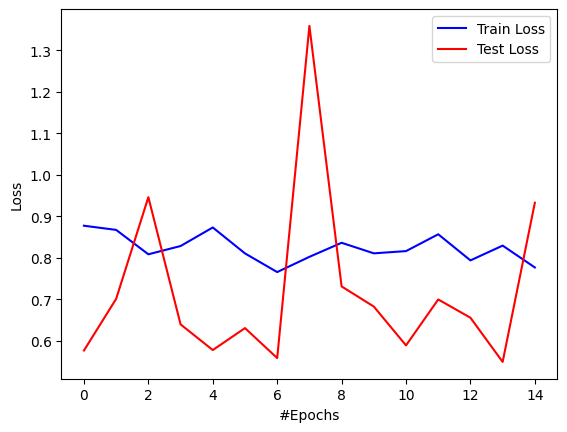

In [53]:
# Test function, run trained model on test set, collect predictions
#Training parameters
num_epochs = EPOCHS_Q1
print_interval = 5
learning_rate = LR_Q1
batch_size = BATCH_SIZE_Q1

image_w = IMG_SIZE_Q1
image_h = IMG_SIZE_Q1

#Create model
predModel = LinearClassifier(image_w, image_h, 1)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.Adam
# loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([penalty]))
loss_function = nn.BCEWithLogitsLoss()


#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(train_dataset_q1, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(test_dataset_q1, batch_size=batch_size)
# training_generator = torch.utils.data.DataLoader(train_dataset_small, batch_size=16, shuffle=True)
# testing_generator = torch.utils.data.DataLoader(test_dataset_small, batch_size=16)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)


Train Set: Accuracy: 3778/6387 (59.2%)
Precision: 0.5436131386861314
Recall: 0.9650145772594753
F1: 0.695459320649002

Test Set: Accuracy: 973/2003 (48.6%)
Precision: 0.2586466165413534
Recall: 0.8865979381443299
F1: 0.40046565774155995


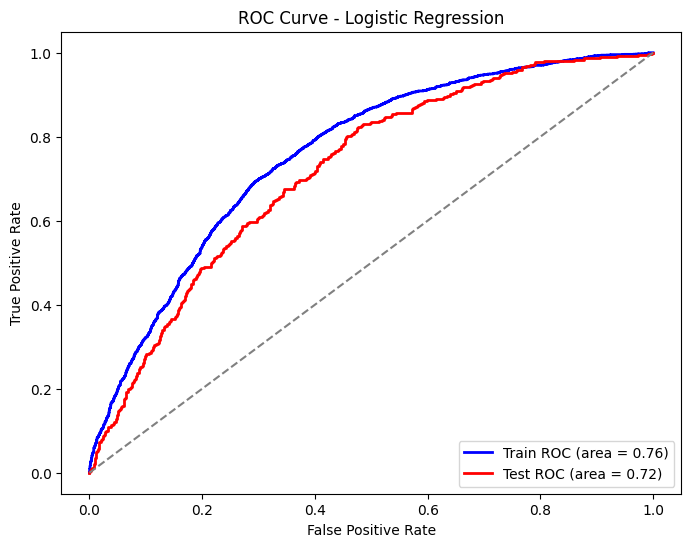

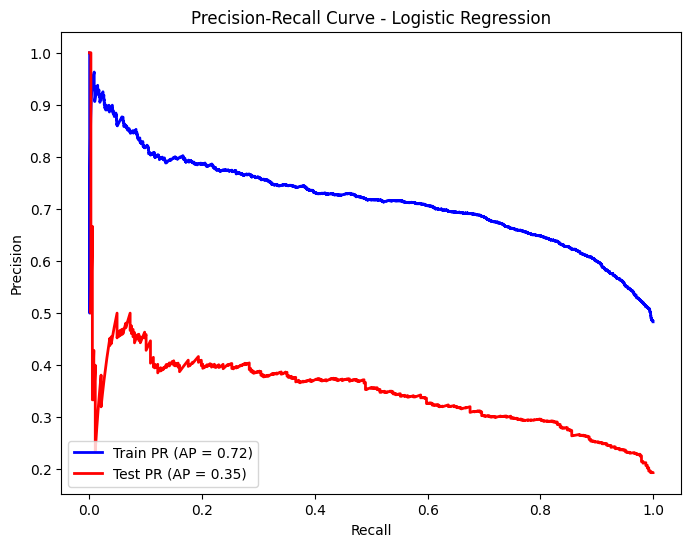

Train AUC: 0.7580343277282052 Test AUC: 0.7204924834828125
Train AP: 0.7168660021094101 Test AP: 0.3484931096487761
{np.int64(0): {'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'Count': 228}, np.int64(1): {'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'Count': 1338}, np.int64(2): {'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'Count': 28}, np.int64(3): {'Precision': 1.0, 'Recall': 0.8628318584070797, 'F1': 0.9263657957244655, 'Count': 226}, np.int64(4): {'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'Count': 21}, np.int64(5): {'Precision': 1.0, 'Recall': 0.9354838709677419, 'F1': 0.9666666666666667, 'Count': 93}, np.int64(6): {'Precision': 1.0, 'Recall': 0.8985507246376812, 'F1': 0.9465648854961832, 'Count': 69}}


In [57]:
# Find results, numeric analysis
computeLabelAccuracy(model, training_generator, "Train Set")
computeLabelAccuracy(model, testing_generator, "Test Set")

# Train predictions
train_preds, train_labels, train_subtypes = [], [], []
model.eval()
with torch.no_grad():
    for data, binary_target, multiclass_target, image_id in training_generator:
        output = model(data)
        probs = torch.sigmoid(output).cpu().numpy().flatten()
        train_preds.extend(probs)
        train_labels.extend(binary_target.cpu().numpy().flatten())
        train_subtypes.extend(multiclass_target.cpu().numpy().flatten())

# Test predictions
test_preds, test_labels, test_subtypes = [], [], []
with torch.no_grad():
    for data, binary_target, multiclass_target, image_id in testing_generator:
        output = model(data)
        probs = torch.sigmoid(output).cpu().numpy().flatten()
        test_preds.extend(probs)
        test_labels.extend(binary_target.cpu().numpy().flatten())
        test_subtypes.extend(multiclass_target.cpu().numpy().flatten())

# ROC curves
fpr_train, tpr_train, _ = roc_curve(train_labels, train_preds)
auc_train = roc_auc_score(train_labels, train_preds)

fpr_test, tpr_test, _ = roc_curve(test_labels, test_preds)
auc_test = roc_auc_score(test_labels, test_preds)

plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2,
         label='Train ROC (area = %0.2f)' % auc_train)
plt.plot(fpr_test, tpr_test, color='red', lw=2,
         label='Test ROC (area = %0.2f)' % auc_test)
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()

# PR curves
prec_train, rec_train, _ = precision_recall_curve(train_labels, train_preds)
ap_train = average_precision_score(train_labels, train_preds)

prec_test, rec_test, _ = precision_recall_curve(test_labels, test_preds)
ap_test = average_precision_score(test_labels, test_preds)

plt.figure(figsize=(8,6))
plt.plot(rec_train, prec_train, color='blue', lw=2,
         label='Train PR (AP = %0.2f)' % ap_train)
plt.plot(rec_test, prec_test, color='red', lw=2,
         label='Test PR (AP = %0.2f)' % ap_test)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend(loc="lower left")
plt.show()

print("Train AUC:", auc_train, "Test AUC:", auc_test)
print("Train AP:", ap_train, "Test AP:", ap_test)

subtype_results = subtype_performance(
    y_true=np.array(test_labels),        # binary ground truth
    y_probs=np.array(test_preds),        # predicted probabilities
    subtype_labels=np.array(test_subtypes),  # per-sample subtype labels
    threshold=0.3
)
print(subtype_results)

Results
modify the threshold based off the PR, lowering the threshold to improve the recall, meaning less false negatives at the cost of more false positives.

Q2:
KNN + PCA

In [44]:
print(train_df_balanced['dx'].value_counts())
print("Benign:", (train_df_balanced['binary_label'] == 0).sum(),
      "Malignant:", (train_df_balanced['binary_label'] == 1).sum())

dx
nv       2221
akiec    1100
bcc      1100
mel       887
bkl       871
vasc      121
df         87
Name: count, dtype: int64
Benign: 3300 Malignant: 3087


In [45]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

def df_to_numpy(df):
    images = []
    labels = []
    for idx, row in df.iterrows():
        img = Image.open(row['image_path']).convert('RGB')
        img = transform(img)
        img = img.view(-1).numpy()   # flatten to raw pixels
        images.append(img)
        labels.append(row['binary_label'])
    return np.array(images), np.array(labels)

# Convert train and test DataFrames
X_train, y_train = df_to_numpy(train_df_balanced)
X_test, y_test   = df_to_numpy(test_df)

# PCA dimensionality reduction
pca = PCA(n_components=0.95, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

print("Original feature dimension:", X_train.shape[1])
print("Reduced feature dimension:", X_train_pca.shape[1])

Original feature dimension: 49152
Reduced feature dimension: 69


Train Accuracy: 0.8100829810552685
Train Precision: 0.8246708246708246
Train Recall: 0.7709750566893424
Train F1: 0.7969194709526202
Test Accuracy: 0.7833250124812781
Test Precision: 0.45021645021645024
Test Recall: 0.5360824742268041
Test F1: 0.4894117647058824


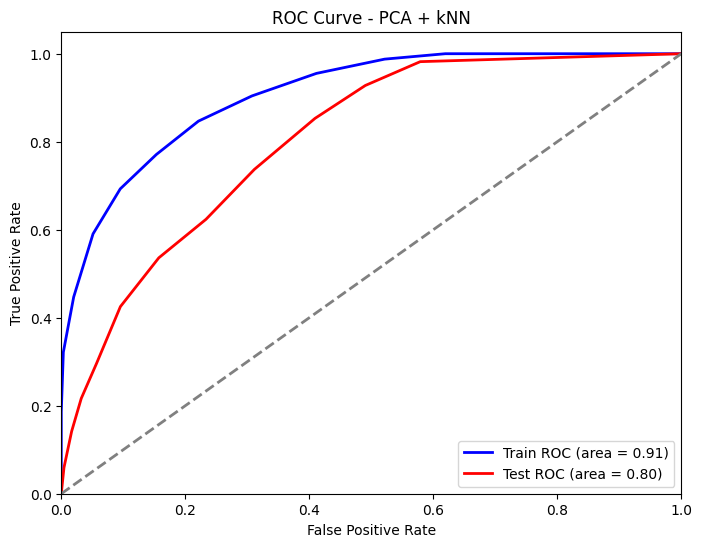

Train AUC: 0.9061198967321417
Test AUC: 0.8031853435894163


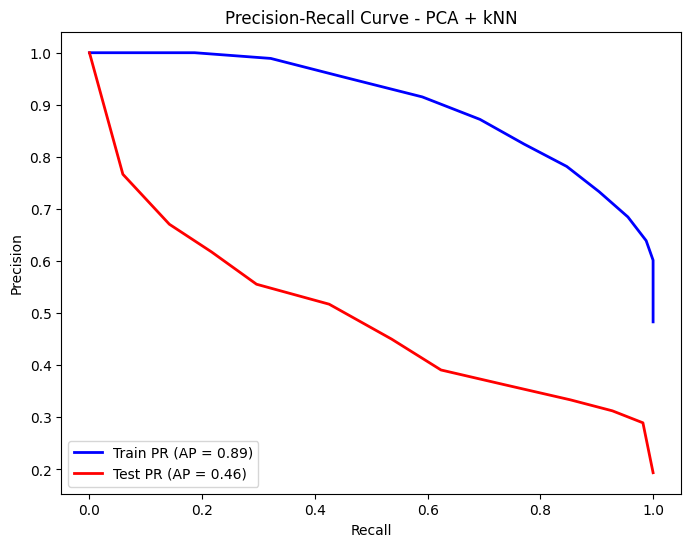

Train Average Precision: 0.8892641884118744
Test Average Precision: 0.4644515347846352


In [47]:
# kNN classifier on PCA features
knn = KNeighborsClassifier(n_neighbors=11, metric='euclidean')
knn.fit(X_train_pca, y_train)

# Training predictions
y_train_pred = knn.predict(X_train_pca)
y_train_probs = knn.predict_proba(X_train_pca)[:,1]

# Training metrics
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train Precision:", precision_score(y_train, y_train_pred))
print("Train Recall:", recall_score(y_train, y_train_pred))
print("Train F1:", f1_score(y_train, y_train_pred))

# Test metrics (already computed, but for completeness)
y_test_pred = knn.predict(X_test_pca)
y_test_probs = knn.predict_proba(X_test_pca)[:,1]

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Precision:", precision_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))
print("Test F1:", f1_score(y_test, y_test_pred))

# Train ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
auc_train = roc_auc_score(y_train, y_train_probs)

# Test ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
auc_test = roc_auc_score(y_test, y_test_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2,
         label='Train ROC (area = %0.2f)' % auc_train)
plt.plot(fpr_test, tpr_test, color='red', lw=2,
         label='Test ROC (area = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # random baseline

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - PCA + kNN')
plt.legend(loc="lower right")
plt.show()

print("Train AUC:", auc_train)
print("Test AUC:", auc_test)


# Test Precision-Recall curve

# Train PR
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_probs)
ap_train = average_precision_score(y_train, y_train_probs)

# Test PR
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_probs)
ap_test = average_precision_score(y_test, y_test_probs)

plt.figure(figsize=(8,6))
plt.plot(recall_train, precision_train, color='blue', lw=2,
         label='Train PR (AP = %0.2f)' % ap_train)
plt.plot(recall_test, precision_test, color='red', lw=2,
         label='Test PR (AP = %0.2f)' % ap_test)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - PCA + kNN')
plt.legend(loc="lower left")
plt.show()

print("Train Average Precision:", ap_train)
print("Test Average Precision:", ap_test)

Results

Q2: SVM

In [48]:
print(train_df_balanced['dx'].value_counts())
print("Benign:", (train_df_balanced['binary_label'] == 0).sum(),
      "Malignant:", (train_df_balanced['binary_label'] == 1).sum())

dx
nv       2221
akiec    1100
bcc      1100
mel       887
bkl       871
vasc      121
df         87
Name: count, dtype: int64
Benign: 3300 Malignant: 3087


Train Accuracy: 0.8572099577266322
Train Precision: 0.8451285306251983
Train Recall: 0.8626498218334953
Train F1: 0.8537992946457198
Test Accuracy: 0.8027958062905641
Test Precision: 0.49290060851926976
Test Recall: 0.6262886597938144
Test F1: 0.5516458569807038


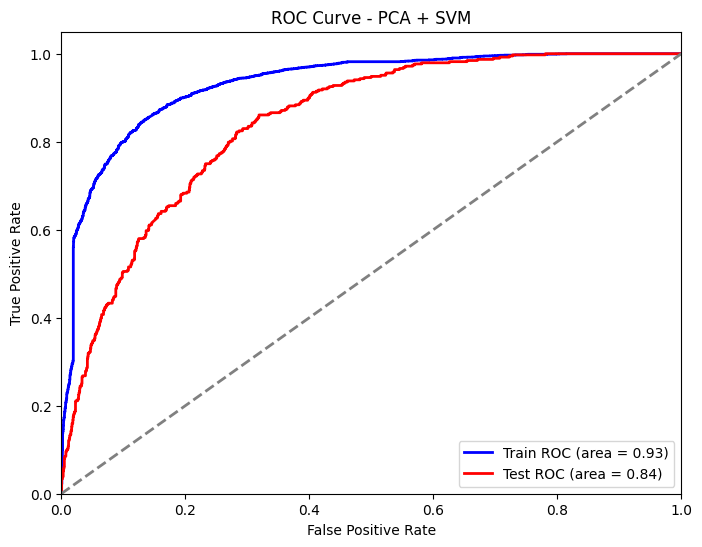

Train AUC: 0.9307560051437602
Test AUC: 0.8427005202515082


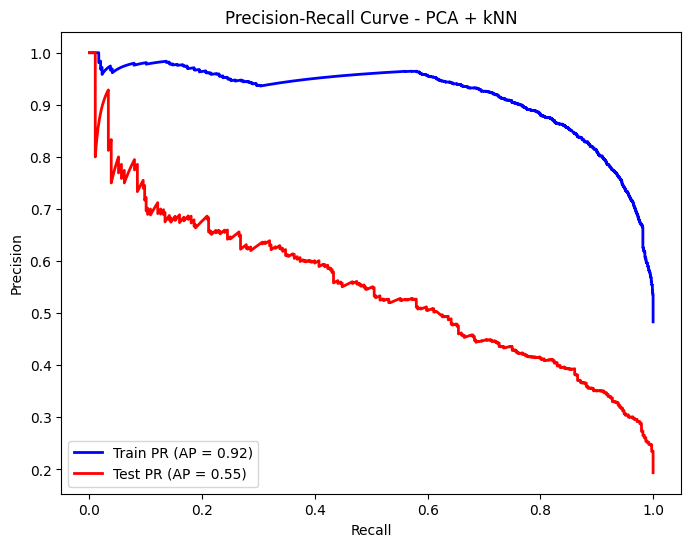

Train Average Precision: 0.9184327707086966
Test Average Precision: 0.5472506284705257


In [49]:
# Train SVM on PCA-reduced features
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_pca, y_train)

# Predictions
y_train_pred = svm.predict(X_train_pca)
y_train_probs = svm.predict_proba(X_train_pca)[:,1]

y_test_pred = svm.predict(X_test_pca)
y_test_probs = svm.predict_proba(X_test_pca)[:,1]

# Metrics
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train Precision:", precision_score(y_train, y_train_pred))
print("Train Recall:", recall_score(y_train, y_train_pred))
print("Train F1:", f1_score(y_train, y_train_pred))

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Precision:", precision_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))
print("Test F1:", f1_score(y_test, y_test_pred))

# Train ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
auc_train = roc_auc_score(y_train, y_train_probs)

# Test ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
auc_test = roc_auc_score(y_test, y_test_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2,
         label='Train ROC (area = %0.2f)' % auc_train)
plt.plot(fpr_test, tpr_test, color='red', lw=2,
         label='Test ROC (area = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # random baseline

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - PCA + SVM')
plt.legend(loc="lower right")
plt.show()

print("Train AUC:", auc_train)
print("Test AUC:", auc_test)


# Test Precision-Recall curve

# Train PR
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_probs)
ap_train = average_precision_score(y_train, y_train_probs)

# Test PR
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_probs)
ap_test = average_precision_score(y_test, y_test_probs)

plt.figure(figsize=(8,6))
plt.plot(recall_train, precision_train, color='blue', lw=2,
         label='Train PR (AP = %0.2f)' % ap_train)
plt.plot(recall_test, precision_test, color='red', lw=2,
         label='Test PR (AP = %0.2f)' % ap_test)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - PCA + kNN')
plt.legend(loc="lower left")
plt.show()

print("Train Average Precision:", ap_train)
print("Test Average Precision:", ap_test)

Q3